In [12]:
# cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

In [13]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [14]:
### Set file names
runningLocation = 'local'
if  runningLocation== 'local':
    hisOSSEFilePath='../data/raw/OSSE_SSHSST/'
    hisTruthFilePath='../data/raw/truth/final/'
    obsFinalFilePath='../data/raw/OSSE_SSHSST/' #the 'final' obs files: Verification obs, + NLmodel values from modTruth.
    modOSSEFilePath='../data/raw/OSSE_SSHSST/'
    # hisPertFilePath='../data/raw/perturbed/'
elif runningLocation == 'gdata':
    hisOSSEFilePath='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
    hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings
    obsFinalFilePath='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
    modOSSEFilePath='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
#     hisPertFilePath='/g/data/fu5/deg581/EAC_2yr_perturbedRun_final/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

### Load functions

In [15]:
### function to load overlapping OSSE data
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

# Now plot results

In [16]:
timeRange = [8005, 8021]


In [17]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

In [18]:
stdFilename = '../data/raw/OSSE_SSHSST/eac_std_i_v2020.nc'

st = xr.open_dataset(stdFilename)

In [19]:

datelist = np.array(range(timeRange[0],timeRange[1],4))

pRangeSSH=405
pRangeSST=340

timeVec = np.zeros(len(datelist))
JobsInitialSST = np.zeros(len(datelist))
JobsInitialSSH = np.zeros(len(datelist))
JobsFinalSST = np.zeros(len(datelist))
JobsFinalSSH = np.zeros(len(datelist))

PostErrBackgroundSST = np.zeros(len(datelist))
PostErrBackgroundSSH = np.zeros(len(datelist))
PostErrObsSST = np.zeros(len(datelist))
PostErrObsSSH = np.zeros(len(datelist))
PriorErrObsSST = np.zeros(len(datelist))
PriorErrObsSSH = np.zeros(len(datelist))
PriorErrBackgroundSST = np.zeros(len(datelist))
PriorErrBackgroundSSH = np.zeros(len(datelist))


rr=0
for dates in datelist:

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

    # filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    # filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    # filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    # sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    # sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    # sshTruth=xr.open_dataset(filenameTruth).zeta.load()
    obsSST = obs.obs_value.where(obs.obs_provenance==pRangeSST,drop=True)
    obsSSH = obs.obs_value.where(obs.obs_provenance==pRangeSSH,drop=True)
    obsErrSST = obs.obs_error.where(obs.obs_provenance==pRangeSST,drop=True)
    obsErrSSH = obs.obs_error.where(obs.obs_provenance==pRangeSSH,drop=True)    
    modInitialSST = mod.NLmodel_initial.where(mod.obs_provenance==pRangeSST,drop=True)
    modInitialSSH = mod.NLmodel_initial.where(mod.obs_provenance==pRangeSSH,drop=True)
    modFinalSST = mod.NLmodel_value.where(mod.obs_provenance==pRangeSST,drop=True)
    modFinalSSH = mod.NLmodel_value.where(mod.obs_provenance==pRangeSSH,drop=True)

    PostErrBackgroundSST[rr] = np.mean(0.5*(modFinalSST-modInitialSST)*(obsSST-modInitialSST))
    PostErrBackgroundSSH[rr] = np.mean(0.5*(modFinalSSH-modInitialSSH)*(obsSSH-modInitialSSH))
    PostErrObsSST[rr] = np.mean(0.5*(obsSST-modFinalSST)*(obsSST-modInitialSST))
    PostErrObsSSH[rr] = np.mean(0.5*(obsSSH-modFinalSSH)*(obsSSH-modInitialSSH))
    PriorErrObsSST[rr] = np.mean(obsErrSST)
    PriorErrObsSSH[rr] = np.mean(obsErrSSH)

    PriorErrBackgroundSSH[rr] = np.nanmean(st.zeta.interp(eta_rho=obs.obs_Ygrid.where(obs.obs_provenance==pRangeSSH,drop=True),xi_rho=obs.obs_Xgrid.where(obs.obs_provenance==pRangeSSH,drop=True),method='linear'))
    PriorErrBackgroundSST[rr] = np.nanmean(st.temp.isel(s_rho=-1).interp(eta_rho=obs.obs_Ygrid.where(obs.obs_provenance==pRangeSST,drop=True),xi_rho=obs.obs_Xgrid.where(obs.obs_provenance==pRangeSST,drop=True),method='linear'))
    
    
    timeVec[rr]=np.nanmean(dates)
    rr=rr+1

    # Ana_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshTruth)**2,axis=2),axis=1))
    # Fore_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast-sshTruth)**2,axis=2),axis=1))
    # Ana_Fore = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshForecast)**2,axis=2),axis=1))
    # time = sshForecast.ocean_time.values
    # if dates == datelist[0]:
    #     ax.plot(time, Fore_Truth, color="C0",label='RMS Forecast-Truth')
    #     ax.plot(time, Ana_Truth, color="C1",label='RMS Analysis-Truth')
    # elif dates != datelist[0]:
    #     ax.plot(time, Fore_Truth, color="C0",label='_nolegend_')
    #     ax.plot(time, Ana_Truth, color="C1",label='_nolegend_')
        
#     ax.plot(time, Ana_Fore, color="C2",label='Truth')
# ax.legend()
# ax.grid()
# ax.tick_params('x',labelrotation=45)


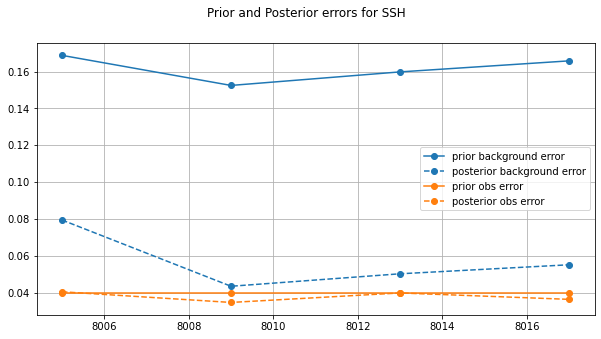

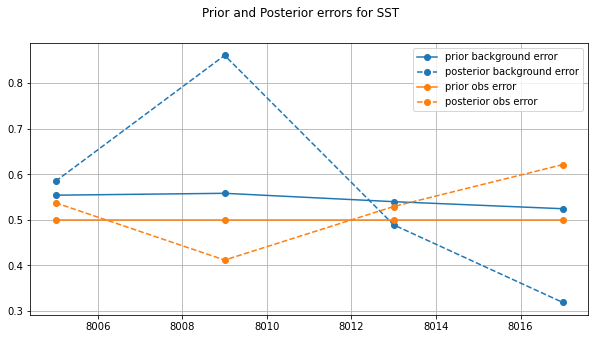

In [9]:
fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(timeVec,PriorErrBackgroundSSH**(1/2),linestyle='-',marker='o',color="C0",label='prior background error')
ax.plot(timeVec,PostErrBackgroundSSH**(1/2), linestyle='--',marker='o',color="C0",label='posterior background error')
ax.plot(timeVec,PriorErrObsSSH**(1/2), linestyle='-',marker='o',color="C1",label='prior obs error')
ax.plot(timeVec,PostErrObsSSH**(1/2), linestyle='--',marker='o',color="C1",label='posterior obs error')
fig.suptitle('Prior and Posterior errors for SSH')
ax.grid()
ax.legend()

fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(timeVec,PriorErrBackgroundSST**(1/2),linestyle='-',marker='o',color="C0",label='prior background error')
ax.plot(timeVec,PostErrBackgroundSST**(1/2), linestyle='--',marker='o',color="C0",label='posterior background error')
ax.plot(timeVec,PriorErrObsSST**(1/2), linestyle='-',marker='o',color="C1",label='prior obs error')
ax.plot(timeVec,PostErrObsSST**(1/2), linestyle='--',marker='o',color="C1",label='posterior obs error')
fig.suptitle('Prior and Posterior errors for SST')
ax.grid()
ax.legend()

In [20]:
# 5th cycle
cycleName = 'with BGQC'
filenameObs = obsFinalFilePath+'obs.nc'
filenameMod = modOSSEFilePath+'eac_mod.nc'

obs = xr.open_dataset(filenameObs).load()
mod = xr.open_dataset(filenameMod).load()

rr=5
dates=8021

obsSST = obs.obs_value.where(obs.obs_provenance==pRangeSST,drop=True)
obsSSH = obs.obs_value.where(obs.obs_provenance==pRangeSSH,drop=True)
obsErrSST = obs.obs_error.where(obs.obs_provenance==pRangeSST,drop=True)
obsErrSSH = obs.obs_error.where(obs.obs_provenance==pRangeSSH,drop=True)    
modInitialSST = mod.NLmodel_initial.where(obs.obs_provenance==pRangeSST,drop=True)
modInitialSSH = mod.NLmodel_initial.where(obs.obs_provenance==pRangeSSH,drop=True)
modFinalSST = mod.NLmodel_value.where(obs.obs_provenance==pRangeSST,drop=True)
modFinalSSH = mod.NLmodel_value.where(obs.obs_provenance==pRangeSSH,drop=True)

PostErrBackgroundSST = np.append(PostErrBackgroundSST,np.mean(0.5*(modFinalSST-modInitialSST)*(obsSST-modInitialSST)))
PostErrBackgroundSSH = np.append(PostErrBackgroundSSH,np.mean(0.5*(modFinalSSH-modInitialSSH)*(obsSSH-modInitialSSH)))
PostErrObsSST = np.append(PostErrObsSST,np.mean(0.5*(obsSST-modFinalSST)*(obsSST-modInitialSST)))
PostErrObsSSH = np.append(PostErrObsSSH,np.mean(0.5*(obsSSH-modFinalSSH)*(obsSSH-modInitialSSH)))
PriorErrObsSST = np.append(PriorErrObsSST,np.mean(obsErrSST))
PriorErrObsSSH = np.append(PriorErrObsSSH,np.mean(obsErrSSH))

PriorErrBackgroundSSH = np.append(PriorErrBackgroundSSH,np.nanmean(st.zeta.interp(eta_rho=obs.obs_Ygrid.where(obs.obs_provenance==pRangeSSH,drop=True),xi_rho=obs.obs_Xgrid.where(obs.obs_provenance==pRangeSSH,drop=True),method='linear')))
PriorErrBackgroundSST = np.append(PriorErrBackgroundSST,np.nanmean(st.temp.isel(s_rho=-1).interp(eta_rho=obs.obs_Ygrid.where(obs.obs_provenance==pRangeSST,drop=True),xi_rho=obs.obs_Xgrid.where(obs.obs_provenance==pRangeSST,drop=True),method='linear')))
timeVec=np.append(timeVec,np.nanmean(dates))

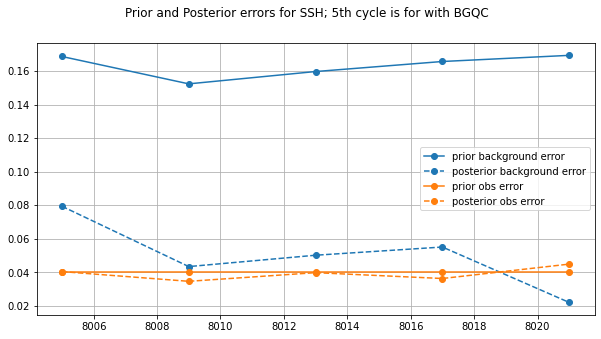

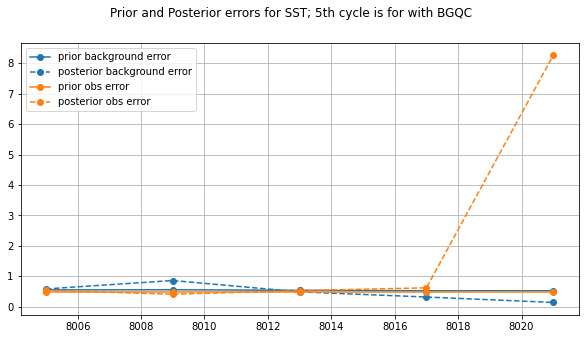

In [21]:
fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(timeVec,PriorErrBackgroundSSH**(1/2),linestyle='-',marker='o',color="C0",label='prior background error')
ax.plot(timeVec,PostErrBackgroundSSH**(1/2), linestyle='--',marker='o',color="C0",label='posterior background error')
ax.plot(timeVec,PriorErrObsSSH**(1/2), linestyle='-',marker='o',color="C1",label='prior obs error')
ax.plot(timeVec,PostErrObsSSH**(1/2), linestyle='--',marker='o',color="C1",label='posterior obs error')
fig.suptitle('Prior and Posterior errors for SSH; 5th cycle is for '+cycleName)
ax.grid()
ax.legend()

fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(timeVec,PriorErrBackgroundSST**(1/2),linestyle='-',marker='o',color="C0",label='prior background error')
ax.plot(timeVec,PostErrBackgroundSST**(1/2), linestyle='--',marker='o',color="C0",label='posterior background error')
ax.plot(timeVec,PriorErrObsSST**(1/2), linestyle='-',marker='o',color="C1",label='prior obs error')
ax.plot(timeVec,PostErrObsSST**(1/2), linestyle='--',marker='o',color="C1",label='posterior obs error')
fig.suptitle('Prior and Posterior errors for SST; 5th cycle is for '+cycleName)
ax.grid()
ax.legend()

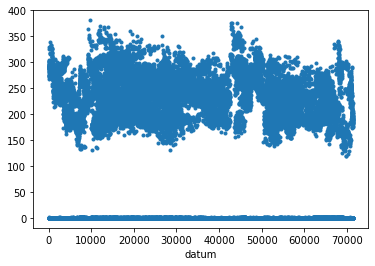

In [43]:
(0.5*(obsSST-modFinalSST)*(obsSST-modInitialSST)).plot(linestyle='none',marker='.')